# Second approach

In [381]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import sympy as sp

In [382]:
plt.style.use(plt.style.available[9])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define Transfer Function

In [383]:
numerator = [-1, 1.9, 0.95]
denominator = [1, -0.18, 0.08, -0.08]
H_s = ctrl.tf(numerator,denominator)
H_s

TransferFunction(array([-1.  ,  1.9 ,  0.95]), array([ 1.  , -0.18,  0.08, -0.08]))

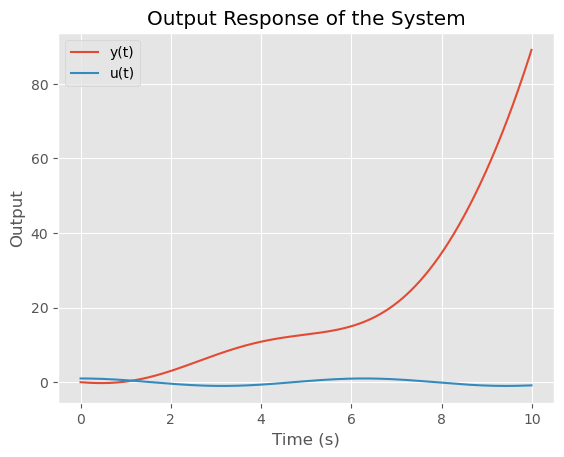

In [384]:
dt =0.01
time = np.arange(0, 10, dt)
f = 1
u_data = np.cos(f*time)#+np.cos(2*time)+np.cos(3*time)

# Step 3: Simulate the output using forced_response
results = ctrl.forced_response(H_s, T=time, U=u_data)

# Plotting the results
plt.figure()
plt.plot(results.time, results.outputs,label='y(t)')
plt.plot(time,u_data,label='u(t)')
plt.title('Output Response of the System')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.legend()

plt.show()

## Neural Network

In [385]:
class DeepNetwork(torch.nn.Module):
    def __init__(self, input_dim=8, hidden_dims=[128, 128, 128], num_classes=5):
        super(DeepNetwork, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        
        # Build the hidden layers
        for i in range(len(dims) - 1):
            layers.append(torch.nn.Linear(dims[i], dims[i + 1]))
            layers.append(torch.nn.ReLU())
        
        # Output layer
        layers.append(torch.nn.Linear(dims[-1], num_classes))
        
        # Sequentially stack the layers
        self.model = torch.nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

## Generating White Noise Data

In [386]:
def generate_delayed_data(data, delays):
    delayed_data = []
    for delay in delays:
        padded_data = torch.cat([torch.zeros(delay), data[:-delay]])
        delayed_data.append(padded_data)
    return torch.stack(delayed_data, dim=1)

In [387]:
# Example white noise input signal
torch.manual_seed(42)
input_signal = torch.randn(50)
time = np.arange(0, 10, 0.2)
input_delays = [1, 2]
output_delays = [1, 2]

# Generate delayed input data
input_data_d = generate_delayed_data(input_signal, input_delays)
input_data = torch.cat([input_signal.reshape(-1, 1), input_data_d], dim=1).to(device)

# Generate system response using control library
T, y_ = ctrl.forced_response(H_s, T=time, U=input_signal.numpy())

# Convert output response to PyTorch tensor and generate delayed outputs
output_signal = torch.from_numpy(y_)  # Convert to PyTorch tensor
output_data = generate_delayed_data(output_signal, output_delays).to(device)

In [388]:
model = DeepNetwork(input_dim=input_data.shape[1] + output_data.shape[1], hidden_dims=[64], num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare the data
X = torch.cat([input_data, output_data], dim=1).to(device).float()
y = torch.from_numpy(y_).to(device).float().reshape(-1,1)

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    if epoch %5000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 62.48456573486328
Epoch 5000, Loss: 0.00017226494674105197


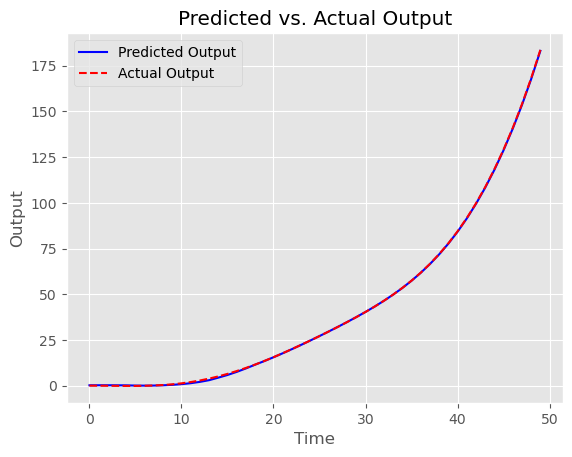

In [389]:
# Test the model with a new input signal (e.g., a sine wave)
test_input = torch.sin(torch.linspace(0, 10, 50))
test_input_data = generate_delayed_data(test_input, input_delays)
test_input_data = torch.cat([test_input.reshape(-1, 1), test_input_data], dim=1).to(device)

T, y_ = ctrl.forced_response(H_s, T=time, U=test_input.numpy())
test_output_data = generate_delayed_data(torch.from_numpy(y_), output_delays).to(device)
X_test = torch.cat([test_input_data, test_output_data], dim=1).to(device).float()

# Combine delayed test input and output for prediction
X_test = torch.cat([test_input_data, test_output_data], dim=1).to(device).float()
predicted_output = model(X_test)

# Plot predicted output and actual output
plt.plot(predicted_output.detach().cpu().numpy(), label="Predicted Output", color="blue")
T, y_ = ctrl.forced_response(H_s, T=time, U=test_input.numpy())
plt.plot(y_, label="Actual Output", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.title("Predicted vs. Actual Output")
plt.show()

# Part II

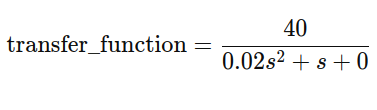
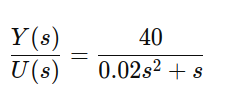
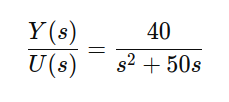

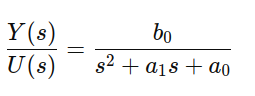
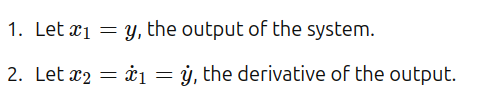
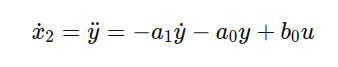


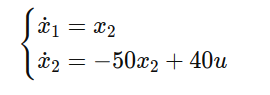
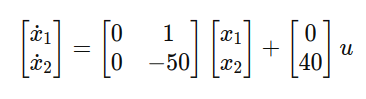

State parameters are the result of x1 and x2 when the sine wave is the input to the system. These states are obtained by solving the differential equation above.

## Neural Network

In [390]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepNetwork(torch.nn.Module):
    def __init__(self, input_dim=8, hidden_dims=[128, 128, 128], num_classes=5):
        super(DeepNetwork, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        
        # Build the hidden layers
        for i in range(len(dims) - 1):
            layers.append(torch.nn.Linear(dims[i], dims[i + 1]))
            layers.append(torch.nn.Sigmoid())
        
        # Output layer
        layers.append(torch.nn.Linear(dims[-1], num_classes))
        
        # Sequentially stack the layers
        self.model = torch.nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

## Filter

In [391]:
def GetTheFilter_StateSpaceMats(A:sp.MutableDenseMatrix):
    s = sp.symbols('s')

    I = sp.eye(A.cols)
    
    M_s = (s*I-A).inv()
    sp.pprint(M_s)


    nums=[]
    dens=[]

    for entry in M_s:
        num_expr = sp.numer(entry)
        den_expr = sp.denom(entry)
        num_poly = sp.Poly(num_expr, s)
        den_poly = sp.Poly(den_expr, s)
        num_coeffs = [float(coef) for coef in num_poly.coeffs()]
        den_coeffs = [float(coef) for coef in den_poly.coeffs()]
        nums.append(num_coeffs)
        dens.append(den_coeffs)

    def GetNumDenReady(size,input):
        output = [[] for i in range(size)]

        for index, item in enumerate(input):
            group_index = index % size
            output[group_index].append(item)
        return output
    
    nums = GetNumDenReady(M_s.cols,nums)
    dens = GetNumDenReady(M_s.cols,dens)
    M_system = ctrl.tf(nums, dens)
    ss_sys = ctrl.tf2ss(M_system) 
    A = ss_sys.A
    B = ss_sys.B
    C = ss_sys.C
    D = ss_sys.D
    return M_system
A_filter = 1*sp.eye(1)
Filter = GetTheFilter_StateSpaceMats(A_filter)
Filter


⎡  1  ⎤
⎢─────⎥
⎣s - 1⎦


TransferFunction(array([1.]), array([ 1., -1.]))

## System

In [392]:
numerator = [1]
denominator = [1,0]
H_s = ctrl.tf(numerator,denominator)
H_s

TransferFunction(array([1]), array([1, 0]))

### input signal

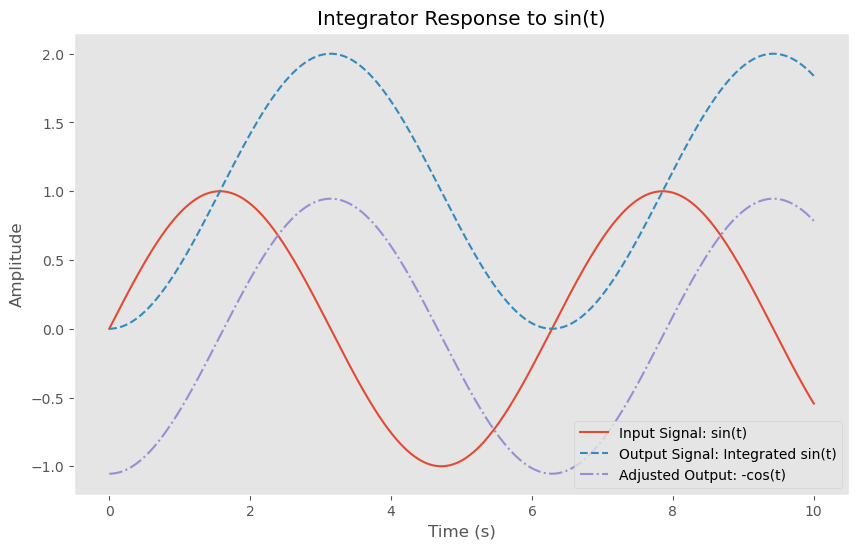

In [393]:
# Define time and input signal
num_pints = 1000
T_end = 10
t = np.linspace(0, T_end, num_pints)  # Time vector
input_signal = np.sin(t)  # Input signal

# Simulate the response
t_out, y_out_ = ctrl.forced_response(H_s, T=t, U=input_signal)

# Remove the DC offset (mean value)
y_out = y_out_ - np.mean(y_out_)

# Plot the input and output signals
plt.figure(figsize=(10, 6))
plt.plot(t, input_signal, label="Input Signal: sin(t)")
plt.plot(t_out, y_out_, label="Output Signal: Integrated sin(t)", linestyle='--')
plt.plot(t_out, y_out, label="Adjusted Output: -cos(t)", linestyle='-.')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Integrator Response to sin(t)")
plt.legend()
plt.grid()
plt.show()

### Train signal

In [394]:
torch.manual_seed(42)
input_signal_ = torch.randn(num_pints)
time = np.arange(0, T_end, T_end/num_pints)

T_, y_ = ctrl.forced_response(H_s, T=time, U=input_signal_)

output_signal = torch.from_numpy(y_).to(device)

x_hat = torch.rand_like(input_signal_)

# Prepare the data
X = torch.cat([input_signal_.reshape(-1, 1), x_hat.reshape(-1, 1)], dim=1).to(device).float()
y = torch.from_numpy(y_).to(device).float().reshape(-1,1)


print(f'input_signal_ shape: {input_signal_.shape}')
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')


input_signal_ shape: torch.Size([1000])
X shape: torch.Size([1000, 2])
y shape: torch.Size([1000, 1])


In [395]:
input_signal_torch = torch.from_numpy(input_signal).reshape(-1,1).to(device)
X = torch.cat([input_signal_torch, input_signal_torch], dim=1).to(device).float()
y = torch.from_numpy(y_out).to(device).float().reshape(-1,1)

model = DeepNetwork(input_dim=X.shape[1], hidden_dims=[64], num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)    
    x_hat = outputs.detach() 
    T_, x_hat = ctrl.forced_response(Filter, T=time, U=x_hat.reshape(-1,).cpu().numpy())
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    
    X = torch.cat([input_signal_.reshape(-1, 1).to(device), torch.from_numpy(x_hat).reshape(-1,1).to(device)], dim=1).float()
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.5499393343925476
Epoch 1000, Loss: 0.23519283533096313
Epoch 2000, Loss: 0.3197447955608368
Epoch 3000, Loss: 0.3867967128753662
Epoch 4000, Loss: 0.43135568499565125
Epoch 5000, Loss: 0.0070902626030147076
Epoch 6000, Loss: 0.0006784386350773275
Epoch 7000, Loss: 0.0002934834628831595
Epoch 8000, Loss: 0.0002511223137844354
Epoch 9000, Loss: 0.00023829122073948383


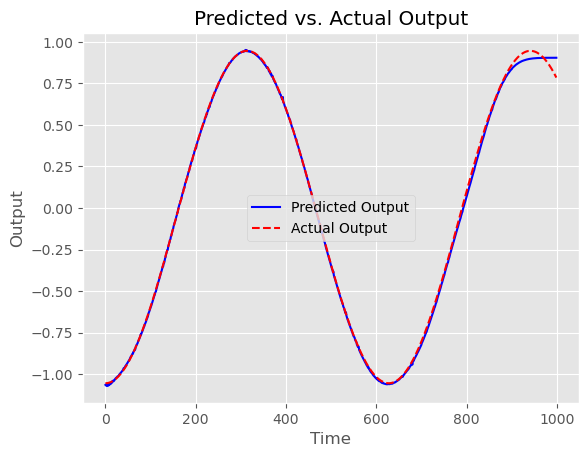

In [396]:
input_signal_torch = torch.from_numpy(input_signal).reshape(-1,1)
X_test = X

# Combine delayed test input and output for prediction
predicted_output = model(X_test)

# Plot predicted output and actual output
plt.plot(predicted_output.detach().cpu().numpy(), label="Predicted Output", color="blue")
plt.plot(y_out, label="Actual Output", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.title("Predicted vs. Actual Output")
plt.show()

# Practice 1

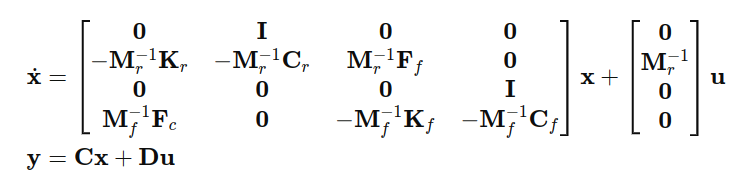
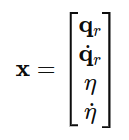
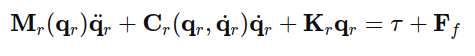

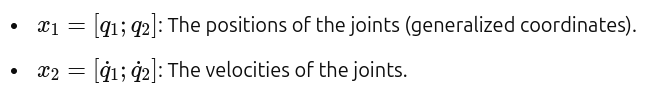
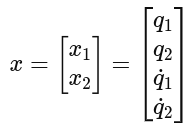

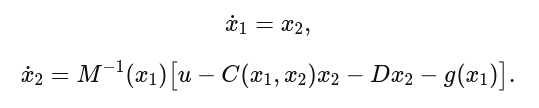
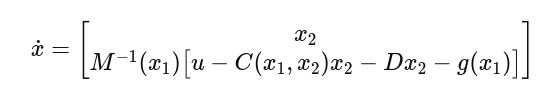

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define constants
a1, a2, a3, a4 = 200.01, 23.5, 122.5, 25
b1, b2 = 784.8, 245.25

# Dynamics functions
def inertia_matrix(q2):
    """Compute the inertia matrix M."""
    M = np.array([
        [a1 + 2 * a4 * np.cos(q2), a2 + a4 * np.cos(q2)],
        [a2 + a4 * np.cos(q2), a3]
    ])
    return M

def coriolis_matrix(q1_dot, q2_dot, q2):
    """Compute the Coriolis matrix C."""
    C = a4 * np.sin(q2) * np.array([
        [-q2_dot, -(q1_dot + q2_dot)],
        [q1_dot, 0]
    ])
    return C

def gravity_vector(q1, q2):
    """Compute the gravity vector g."""
    g = np.array([
        b1 * np.cos(q1) + b2 * np.cos(q1 + q2),
        b2 * np.cos(q1 + q2)
    ])
    return g

# Desired trajectory
def desired_trajectory(t):
    """Desired trajectory for the end effector."""
    q_d = np.sin(10 * t)
    q_d_dot = 10 * np.cos(10 * t)
    q_d_ddot = -100 * np.sin(10 * t)
    return q_d, q_d_dot, q_d_ddot

# Dynamics model
def robot_dynamics(t, state, u_func):
    """Compute the state derivatives."""
    q1, q2, q1_dot, q2_dot = state
    x1 = np.array([q1, q2])
    x2 = np.array([q1_dot, q2_dot])

    M = inertia_matrix(q2)
    C = coriolis_matrix(q1_dot, q2_dot, q2)
    g = gravity_vector(q1, q2)

    # Control input
    u = u_func(t, state)

    # Compute accelerations
    x2_dot = np.linalg.inv(M) @ (u - C @ x2 - g)

    # Return state derivatives
    return np.hstack((x2, x2_dot))

# Initial conditions
initial_state = [0, 0, 0, 0]  # [q1, q2, q1_dot, q2_dot]
t_span = (0, 5)               # Time interval
t_eval = np.linspace(*t_span, 1000)  # Evaluation times
u = np.sin(10 * t)

dx1_dx2 = robot_dynamics(initial_state, u)

(1000,)


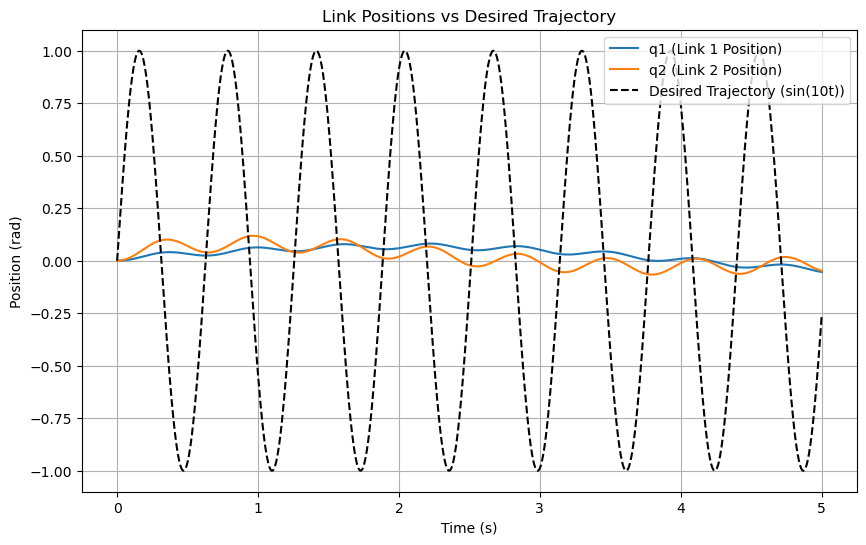

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define constants
a1, a2, a3, a4 = 200.01, 23.5, 122.5, 25
b1, b2 = 784.8, 245.25

# Dynamics functions
def inertia_matrix(q2):
    """Compute the inertia matrix M."""
    M = np.array([
        [a1 + 2 * a4 * np.cos(q2), a2 + a4 * np.cos(q2)],
        [a2 + a4 * np.cos(q2), a3]
    ])
    return M

def coriolis_matrix(q1_dot, q2_dot, q2):
    """Compute the Coriolis matrix C."""
    C = a4 * np.sin(q2) * np.array([
        [-q2_dot, -(q1_dot + q2_dot)],
        [q1_dot, 0]
    ])
    return C

def gravity_vector(q1, q2):
    """Compute the gravity vector g."""
    g = np.array([
        b1 * np.cos(q1) + b2 * np.cos(q1 + q2),
        b2 * np.cos(q1 + q2)
    ])
    return g

# Desired trajectory
def desired_trajectory(t):
    """Desired trajectory for the end effector."""
    q_d = np.sin(10 * t)
    q_d_dot = 10 * np.cos(10 * t)
    q_d_ddot = -100 * np.sin(10 * t)
    return q_d, q_d_dot, q_d_ddot

# Dynamics model
def robot_dynamics(t, state, u_func):
    """Compute the state derivatives."""
    q1, q2, q1_dot, q2_dot = state
    x1 = np.array([q1, q2])
    x2 = np.array([q1_dot, q2_dot])

    M = inertia_matrix(q2)
    C = coriolis_matrix(q1_dot, q2_dot, q2)
    g = gravity_vector(q1, q2)

    # Control input
    u = u_func(t, state)

    # Compute accelerations
    x2_dot = np.linalg.inv(M) @ (u - C @ x2 - g)

    # Return state derivatives
    return np.hstack((x2, x2_dot))

# Control input (PD control with gravity compensation)
def control_input(t, state):
    """Compute the control input u."""
    q1, q2, q1_dot, q2_dot = state
    q_d, q_d_dot, q_d_ddot = desired_trajectory(t)

    # PD control gains
    Kp = np.array([[150, 0], [0, 150]])  # Proportional gain
    Kd = np.array([[50, 0], [0, 50]])    # Derivative gain

    # Errors
    x1 = np.array([q1, q2])
    x2 = np.array([q1_dot, q2_dot])
    e = np.array([q_d, q_d]) - x1
    e_dot = np.array([q_d_dot, q_d_dot]) - x2

    # PD control law
    u = Kp @ e + Kd @ e_dot + gravity_vector(q1, q2)
    return u

# Initial conditions
initial_state = [0, 0, 0, 0]  # [q1, q2, q1_dot, q2_dot]
t_span = (0, 5)               # Time interval
t_eval = np.linspace(*t_span, 1000)  # Evaluation times

# Simulate the system
solution = solve_ivp(
    robot_dynamics, t_span, initial_state, t_eval=t_eval, args=(control_input,)
)

# Extract results
t = solution.t
q1, q2 = solution.y[0], solution.y[1]

# Desired trajectory
q_d = np.sin(10 * t)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(t, q1, label="q1 (Link 1 Position)")
plt.plot(t, q2, label="q2 (Link 2 Position)")
plt.plot(t, q_d, '--', label="Desired Trajectory (sin(10t))", color='black')
plt.xlabel("Time (s)")
plt.ylabel("Position (rad)")
plt.title("Link Positions vs Desired Trajectory")
plt.legend()
plt.grid()
plt.show()
